In [ ]:
#default_exp preprocessing

# Preprocessing

> Make png mask for DL models.

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from steel_segmentation.core import *
from steel_segmentation.data import *
from fastcore.foundation import *
from fastai.vision.all import *
from PIL import Image
from collections import defaultdict
from matplotlib import pyplot as plt 

import pandas as pd
import numpy as np

/home/mmb/miniconda3/envs/env_nbdev/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


For FastAI Segmentation DataLoader we need to build :

1. the codes: the type of pixels in the images

2. the labels: the masks for each image

3. Cropping the images

## Codes (opt.)

Codes are the labels for the corrisponding pixel values in the mask images.

In [ ]:
codes_file_name = "codes.txt"
codes_path = Path(path/codes_file_name)

if not codes_path.is_file():
    classes = np.unique(train.ClassId.values)
    classes = np.insert(classes, 0, 0)
    np.savetxt(path/'codes.txt', classes, fmt='%u')
else:
    classes = np.loadtxt(codes_path, dtype=np.uint8)

classes

array([0, 1, 2, 3, 4], dtype=uint8)

## Labels

Labels are the masks for the training images. 

As a first approach, i tried to create masks only for the images that present a defect. But this will exclude all the good images that can be used to teach to the model to recognize good steel pixels.

Now I created the masks for all the images in the training folder.

**NB: masks must be PNG files and not JPEG because JPEG's compression makes the labels get messed up occasionally** ([source](https://forums.fast.ai/t/unet-learner-failing-with-a-cuda-device-assert/66747/4)).

In [ ]:
#export
labels_dir = path / "labels"

def create_masks(df: pd.DataFrame):
    """Create the mask files under the `labels_dir`"""
    for img_id in df["ImageId"].tolist():
        img_path = train_path / img_id
        mask = multi_rle_to_mask(img_path)
        im = Image.fromarray(mask)
        im.save(labels_dir/f"{img_path.stem}_P.png")

In [ ]:
#hide
# !rm -rf {str(labels_dir)}

In [ ]:
#slow
if not labels_dir.is_dir():
    labels_dir.mkdir(parents=True, exist_ok=True)
    create_masks(train_all)

labels_dir.ls()

(#6667) [Path('../data/labels/0002cc93b_P.png'),Path('../data/labels/0007a71bf_P.png'),Path('../data/labels/000a4bcdd_P.png'),Path('../data/labels/000f6bf48_P.png'),Path('../data/labels/0014fce06_P.png'),Path('../data/labels/0025bde0c_P.png'),Path('../data/labels/002af848d_P.png'),Path('../data/labels/002fc4e19_P.png'),Path('../data/labels/0030401a5_P.png'),Path('../data/labels/0046839bd_P.png')...]

With the PNG extension, the multi-label segmentation problem would seem desappear.

In [ ]:
#hide
mask_paths = get_image_files(labels_dir)
mask_paths

(#6667) [Path('../data/labels/0002cc93b_P.png'),Path('../data/labels/0007a71bf_P.png'),Path('../data/labels/000a4bcdd_P.png'),Path('../data/labels/000f6bf48_P.png'),Path('../data/labels/0014fce06_P.png'),Path('../data/labels/0025bde0c_P.png'),Path('../data/labels/002af848d_P.png'),Path('../data/labels/002fc4e19_P.png'),Path('../data/labels/0030401a5_P.png'),Path('../data/labels/0046839bd_P.png')...]

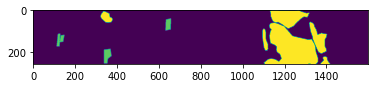

In [ ]:
#missing
plt.imshow(np.array(Image.open(mask_paths[100])));

In [ ]:
#hide
# Test if all is working as expected
dotest = False
if dotest:
    n = len(mask_paths)
    idx = get_random_idx(n)
    pixels = set()
    for p in mask_paths[idx]:
        pixels_founded = np.unique(np.array(Image.open(p)))
        pixels = pixels.union(set(pixels_founded))
    pixels

## Cropping

The standard size of the images is `(256, 1600)` and maybe it's because of this that I always go out of memory in the GPU.

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02_preprocessing.ipynb.
Converted index.ipynb.
